In [1]:
import os
import torch
import torchsig

import numpy as np
import torch.nn.functional as F
import torchsig.transforms as ST

from datetime import datetime
from matplotlib import pyplot as plt
from models import CustomNetwork
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
from sklearn.metrics import classification_report
from torch import optim
from torch.utils.data import DataLoader
from torchsig.datasets.sig53 import Sig53
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    TargetSNR,
    ComplexTo2D,
)
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from tqdm import tqdm
from typing import List


In [2]:
dataset_path = "./dev_data/torchsig_test/"
num_iq_samples = 1024

In [3]:
transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    allowed_filetypes=[".sigmf-data"],
    transform = transform,
    only_first_samples=True,
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

Adding anom_wifi to class list
Adding mini2_telem to class list
Adding mini2_video to class list
Adding wifi6 to class list
Adding wifi to class list
Adding fhss_css to class list
Class List: ['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']
len(dataset)=96682
{'anom_wifi': 43285, 'mini2_telem': 337, 'mini2_video': 776, 'wifi6': 10569, 'wifi': 41419, 'fhss_css': 296}


In [4]:
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

sampler = dataset.get_weighted_sampler(indices=train_data.indices)

train_dataloader = DataLoader(
    dataset=train_data, #sig53_clean_train ,
    batch_size=180,
    num_workers=16,
    sampler=sampler,
    # shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_data, #sig53_clean_train ,
    batch_size=180,
    num_workers=16,
    shuffle=False,
    drop_last=True,
)

In [5]:
train_class_counts = dataset.get_class_counts(indices=train_data.indices)
train_class_counts = {dataset.class_list[k]:v for k,v in train_class_counts.items()}
val_class_counts = dataset.get_class_counts(indices=val_data.indices)
val_class_counts = {dataset.class_list[k]:v for k,v in val_class_counts.items()}
print(f"{len(train_data)=}, {train_class_counts=}")
print(f"{len(val_data)=}, {val_class_counts=}")

len(train_data)=77346, train_class_counts={'anom_wifi': 34617, 'mini2_telem': 260, 'mini2_video': 615, 'wifi6': 8464, 'wifi': 33140, 'fhss_css': 250}
len(val_data)=19336, val_class_counts={'anom_wifi': 8668, 'mini2_telem': 77, 'mini2_video': 161, 'wifi6': 2105, 'wifi': 8279, 'fhss_css': 46}


# Lightning Model

In [6]:
model = torch.jit.load('weights/checkpoint-v17_torchscript.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = CustomNetwork(model, train_dataloader, val_dataloader)

example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

## Evaluate the Trained Model

In [7]:
# Infer results over validation set
num_test_examples = len(val_data)
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))
y_true_list = []
y_preds_list = []
with torch.no_grad():
    example_model.eval()
    for data, label in tqdm(val_dataloader):
        # Infer
        data = data.float()

        data = data.cuda() if torch.cuda.is_available() else data
        pred_tmp = example_model.predict(data)
        pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp

        y_preds_list.extend(np.argmax(pred_tmp, axis=1).tolist())
        y_true_list.extend(label.tolist())
        
y_preds = y_preds_list
y_true = y_true_list

100%|████████████████████████████████████████████████████████████████████████| 107/107 [00:20<00:00,  5.10it/s]


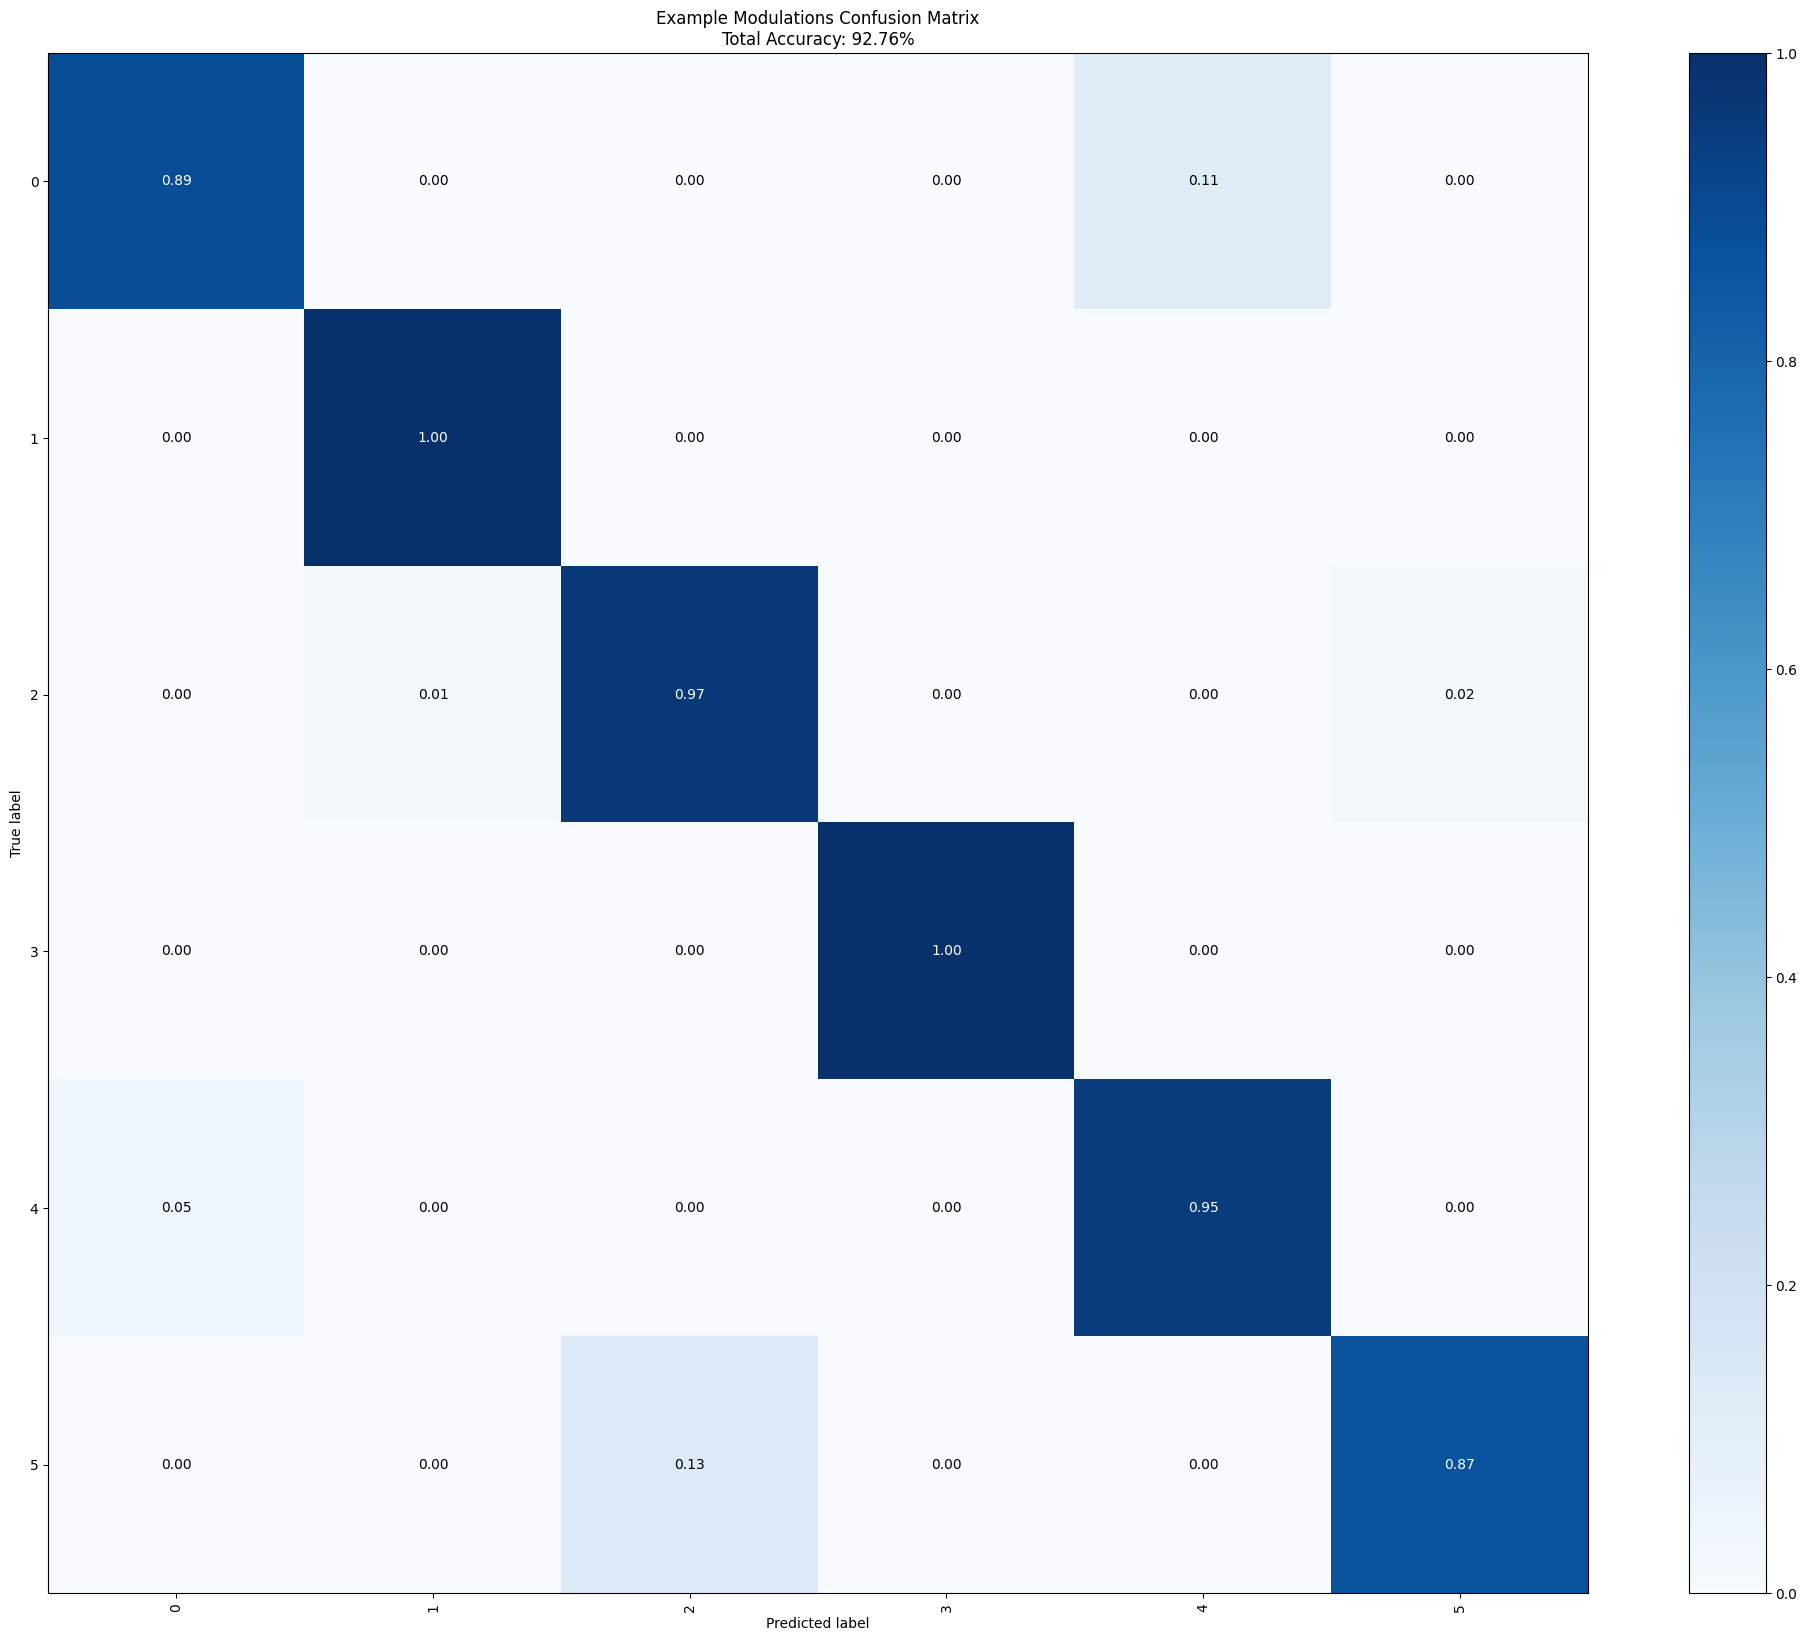

In [8]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=np.unique(np.concatenate((np.arange(len(dataset.class_list)),np.unique(y_preds)))),
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=True,
    rotate_x_text=90,
    figsize=(26,20),
)
plt.show()

In [9]:
{i:c for i,c in enumerate(dataset.class_list)}

{0: 'anom_wifi',
 1: 'mini2_telem',
 2: 'mini2_video',
 3: 'wifi6',
 4: 'wifi',
 5: 'fhss_css'}

In [10]:
for i,c in enumerate(torchsig.datasets.modulations.ModulationsDataset().default_classes):
    print(f"{i}, {c}")

0, ook
1, bpsk
2, 4pam
3, 4ask
4, qpsk
5, 8pam
6, 8ask
7, 8psk
8, 16qam
9, 16pam
10, 16ask
11, 16psk
12, 32qam
13, 32qam_cross
14, 32pam
15, 32ask
16, 32psk
17, 64qam
18, 64pam
19, 64ask
20, 64psk
21, 128qam_cross
22, 256qam
23, 512qam_cross
24, 1024qam
25, 2fsk
26, 2gfsk
27, 2msk
28, 2gmsk
29, 4fsk
30, 4gfsk
31, 4msk
32, 4gmsk
33, 8fsk
34, 8gfsk
35, 8msk
36, 8gmsk
37, 16fsk
38, 16gfsk
39, 16msk
40, 16gmsk
41, ofdm-64
42, ofdm-72
43, ofdm-128
44, ofdm-180
45, ofdm-256
46, ofdm-300
47, ofdm-512
48, ofdm-600
49, ofdm-900
50, ofdm-1024
51, ofdm-1200
52, ofdm-2048
